In [1]:
import pandas as pd
import numpy as np

# Drawing Map

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

In [3]:
# reading csv file containing the coordinates of calgary city
df_boundary = pd.read_csv('City_Boundary_layer.csv')

# reading coordinates
df_coordinates = df_boundary['the_geom']
df_cord = df_coordinates[0][10:].replace(")","")
df_cord_split = df_cord.split(",")

# list of longitudes
lons = [float((x.strip().split())[0]) for x in df_cord_split]

# list of latitudes
lats = [float((x.strip().split())[1]) for x in df_cord_split]

# min and max latitude and longitude values
long_max = max(lons)
long_min = min(lons)
lat_max = max(lats)
lat_min = min(lats)

# coordinates for drawing boundary of calgary
ls = ((lat_max,long_max),(lat_max,long_min),(lat_min,long_min),(lat_min,long_max),(lat_max,long_max))

In [4]:
# central location of calgary city
locat = [51.049999, -114.066666]

# displays the map of Calgary city
m = folium.Map(location = locat, zoom_start=10)

# adding boundary coordinates to the map
folium.PolyLine(ls, color="red", weight=2.5, opacity=1).add_to(m)
m

In [5]:
# dividing into grids
vertical_cord_upper = []
vertical_cord_lower = []
horizontal_cord_left = []
horizontal_cord_right = []

# calculating the coordinates for joining the lines
for i in range(1, 10):
    long = long_min + (i*(long_max - long_min)/10)
    lat = lat_min + (i*(lat_max - lat_min)/10)
    vertical_cord_upper.append((lat_max,long))
    vertical_cord_lower.append((lat_min,long))
    horizontal_cord_left.append((lat, long_min))
    horizontal_cord_right.append((lat, long_max))
    horizontal_cord_right


In [6]:
# plotting the grids
for i in range(0,9):
    vertical_cord = []
    horizontal_cord = []
    vertical_cord.append(vertical_cord_upper[i])
    vertical_cord.append(vertical_cord_lower[i])
    horizontal_cord.append(horizontal_cord_left[i])
    horizontal_cord.append(horizontal_cord_right[i])
    folium.PolyLine(vertical_cord, color="brown", weight=1, opacity=1).add_to(m)
    folium.PolyLine(horizontal_cord, color="brown", weight=1, opacity=1).add_to(m)
m

In [7]:
# get coordinates of the grids
# coordinates are stored as a list of tuples in grid_cord
# Each tuple contains 4 values for lat min, lat max, long min, and long max
grid_cord = []
lat_grid_min = lat_min
long_grid_min = long_min
lat_grid_max = 0
long_grid_max = 0

for i in range (1,11):
    lat_grid_max = lat_grid_min + ((lat_max - lat_min)/10)
    long_grid_min = long_min
    for j in range (1,11):
        long_grid_max = long_grid_min + ((long_max - long_min)/10)
        grid_cord.append((lat_grid_min,lat_grid_max,long_grid_min,long_grid_max))
        long_grid_min = long_grid_max
    lat_grid_min = lat_grid_max

In [8]:
# checking the coordinates
feature_group = folium.FeatureGroup("Locations")
for i in range (0,100):
    values = grid_cord[i]
    #print(values)
    lat_test = (values[0] + values[1])/2
    long_test = (values[2] + values[3])/2
    feature_group.add_child(folium.Marker(location=[lat_test,long_test],popup="sayam"))
m.add_child(feature_group)

# Counting number of cameras in each grid

In [9]:
# counting no of cameras in each grid

# reading csv file for cameras
df_camera = pd.read_csv("Traffic_Camera_Locations.csv")

# dictionary for storing the values
dict_data = {}

# column for adding the number of cameras in each grid
dict_data['num_cameras']= []

# algo for counting the number of cameras in each grid 

# coordinates of each grid
for i in grid_cord:
    
    # checking if the coordinates lie in that grid
    bool_Series = df_camera['latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_camera['longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    
    # getting data corresponding to the coordinates that lie in that grid
    df_camera_filter = df_camera[bool_Series] 

    # appending num of cameras for that grid
    dict_data['num_cameras'].append(df_camera_filter.shape[0])
    
df = pd.DataFrame(dict_data)
df

,num_cameras
0,0
1,0
2,0
3,0
4,0
...,...
95,0
96,0
97,0
98,0


# Calculating Average Speed

In [10]:
# finding average speed limit

# reading speed limits
df_speed = pd.read_csv("Speed_Limits.csv")

# df_speed_loc has only speeds and location coordinates
df_speed_loc = df_speed[['SPEED','multiline']]

# removing extra characters from location
df_speed_loc['multiline'] = df_speed_loc['multiline'].apply(lambda x: x[16:].replace("(","").replace(")",""))

# checks for NAN values
df_speed_loc.isnull().any()

# creating lists for latitude, longitude, and speed for 'speed data'
speed_lat_ls =[]
speed_long_ls = []
speed_ls = []

# algo for getting lats, longs, and speed
for i in range (df_speed_loc.shape[0]):
    coordinates = df_speed_loc.loc[i,'multiline'].split(",")
    for j in coordinates:
        cord_space = j.split()
        speed_long_ls.append(cord_space[0])
        speed_lat_ls.append(cord_space[1])
        speed_ls.append(df_speed_loc.loc[i,'SPEED'])
    
print(len(speed_ls))
print(len(speed_long_ls))
print(len(speed_lat_ls))



C:\Users\Hp-user\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


86969
86969
86969


# Calculating speeds for each grid

In [11]:
# counting average speed in each grid
pd.set_option('display.max_rows', 500)

dict_speed = {'Speed':speed_ls, 'Latitude':speed_lat_ls, 'Longitude':speed_long_ls}

# creating new data frame for speed with lats, longs, and speeds 
df_speed_new = pd.DataFrame.from_dict(dict_speed)
df_speed_new = df_speed_new.astype(float)
#print(df_speed_new)
#print(df_speed_new.dtypes)
avg_speed_ls = []

#i iterates through all the grids
for i in grid_cord:
    
    # checks if coordinate lies in particular grid
    bool_Series = df_speed_new['Latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_speed_new['Longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    
    # getting data corresponding to the coordinates that lie in that grid
    df_speed_new_filter = df_speed_new[bool_Series]
    
    # calculating average of the volumes
    avg_speed_ls.append(df_speed_new_filter['Speed'].mean())


# assigning the vlume data to the data frame
df['avg_speed'] = avg_speed_ls

# appending Nan values to zero
df['avg_speed'] = df['avg_speed'].fillna(0)
df.head()

,num_cameras,avg_speed
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0


# Calculating Average Volumes

Fetching latitudes, longitudes, and volume data

In [12]:
# reading volume file
traffic_vol_csv = pd.read_csv("Traffic_Volumes_for_2018.csv")

# refining data in multilinestring to fetch individual coordinates
traffic_vol_csv['multilinestring'] = traffic_vol_csv['multilinestring'].apply(lambda x: x[16:].replace("(","").replace(")",""))

# creating lists for latitude, longitude, and volume for 'traffic_vol_csv'
vol_lat_list =[]
vol_long_list = []
vol_list = []

# algo for getting lats, longs, and speed
for i in range (traffic_vol_csv.shape[0]):
    coordinates = traffic_vol_csv.loc[i,'multilinestring'].split(",")
    for j in coordinates:
        cord_space = j.split()
        vol_long_list.append(float(cord_space[0]))
        vol_lat_list.append(float(cord_space[1]))
        vol_list.append(float(traffic_vol_csv.loc[i,'VOLUME']))
    
print(len(vol_list))
print(len(vol_long_list))
print(len(vol_lat_list))

41635
41635
41635


Finding average volumes for each grid

In [13]:
df_volume_new = pd.DataFrame({'Volume':vol_list, 'Latitude':vol_lat_list, 'Longitude':vol_long_list})

# list containing average values of volume for all grids
volume_grid_ls = []

#algo for finding the average
#i iterates through all the grids
for i in grid_cord:
    
    # checks if coordinate lies in particular grid
    bool_Series = df_volume_new['Latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_volume_new['Longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    
    # getting data corresponding to the coordinates that lie in that grid
    df_volume_new_filter = df_volume_new[bool_Series]
    
    # calculating average of the volumes
    volume_grid_ls.append(df_volume_new_filter['Volume'].mean()) 


# assigning the vlume data to the data frame
df['avg_volume'] = volume_grid_ls

# appending Nan values to zero
df['avg_volume'] = df['avg_volume'].fillna(0)
df

,num_cameras,avg_speed,avg_volume
0,0,0.000000,0.000000
1,0,0.000000,0.000000
2,0,0.000000,0.000000
3,0,0.000000,0.000000
4,0,0.000000,2000.000000
5,1,59.673203,2509.433962
6,1,66.206897,11914.826498
7,0,80.445545,17805.128205
8,0,0.000000,0.000000
9,0,0.000000,0.000000


# Traffic Signals

In [14]:
# reading traffic signals file
df_signals = pd.read_csv("Traffic_Signals.csv")

# list for appending number of signals in each grid
ls = []

# iterating through grids
for i in grid_cord:
    # checking the latitue and longitudes
    bool_Series = df_signals['latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_signals['longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    # getting the list of signals for a grid that is being iterated
    df_sig = df_signals[bool_Series]
    # appending the count of signals for a grid that is being iterated
    ls.append(df_sig.shape[0])

# adding list of signal to the data frame
df['num_signals'] = ls
df

,num_cameras,avg_speed,avg_volume,num_signals
0,0,0.000000,0.000000,0
1,0,0.000000,0.000000,0
2,0,0.000000,0.000000,0
3,0,0.000000,0.000000,0
4,0,0.000000,2000.000000,0
5,1,59.673203,2509.433962,1
6,1,66.206897,11914.826498,5
7,0,80.445545,17805.128205,7
8,0,0.000000,0.000000,0
9,0,0.000000,0.000000,0


# Number of Traffic Signs

In [15]:
# reading signs.csv file
df_signs = pd.read_csv("Traffic_Signs.csv")

# accessing the coordinates and signs
df_signs = df_signs[['BLADE_TYPE','POINT']]

# refining the coordinate data
df_signs['POINT'] = df_signs['POINT'].apply(lambda x: x[7:].replace(")",""))

# filtering empty rows
df_signs['BLADE_TYPE'].replace('', np.nan, inplace=True)
df_signs.dropna(subset=['BLADE_TYPE'], inplace=True)

# creating latitude and longitude from point
df_signs['latitude'] = df_signs['POINT'].apply(lambda x: x.split()[1])
df_signs['latitude'] = df_signs['latitude'].astype(float)
df_signs['longitude'] = df_signs['POINT'].apply(lambda x: x.split()[0])
df_signs['longitude'] = df_signs['longitude'].astype(float)
print(df_signs.shape)

(207286, 4)


In [16]:
# list for appending number of signs in each grid
ls_signs = []

# iterating through grids
for i in grid_cord:
    # checking the latitue and longitudes
    bool_Series = df_signs['latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_signs['longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    # getting the list of signs for a grid that is being iterated
    df_sig = df_signs[bool_Series]
    # appending the count of signs for a grid that is being iterated
    ls_signs.append(df_sig.shape[0])

print(sum(ls_signs))
# adding list of signs to the data frame
df['num_signs'] = ls_signs
df

207238


,num_cameras,avg_speed,avg_volume,num_signals,num_signs
0,0,0.000000,0.000000,0,0
1,0,0.000000,0.000000,0,0
2,0,0.000000,0.000000,0,0
3,0,0.000000,0.000000,0,0
4,0,0.000000,2000.000000,0,54
5,1,59.673203,2509.433962,1,303
6,1,66.206897,11914.826498,5,1486
7,0,80.445545,17805.128205,7,753
8,0,0.000000,0.000000,0,27
9,0,0.000000,0.000000,0,5


# Daily Weather Conditions

In [17]:
def download_weather_data(station, year, month=1, daily=True):
    """ returns a DataFrame with weather data from climate.weather.gc.ca"""
   # url string with variables station, year and month
    url_template = "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={station}&Year={year}&Month={month}&Day=14&timeframe={time_frame}&submit=Download+Data"

    # replace variables in string with actual values
    if daily:
        url = url_template.format(station = station, year = year, month = month, time_frame = 2)
    else:
        url = url_template.format(station= station, year = year, month = month, time_frame = 1)

    # read data into dataframe, use headers and set Date/Time column as index
    weather_data = pd.read_csv(url, index_col='Date/Time', parse_dates=True)

    # replace the degree symbol in the column names
    weather_data.columns = [col.replace('\xb0', '') for col in weather_data.columns]
    
    return (weather_data)

# getting data 2018
df_weather_temp = download_weather_data(station=50430, year=2018, month=5)
df_weather_vis = download_weather_data(station=50430, year=2018, month=5, daily = False)
display(df_weather_temp.columns, df_weather_temp.shape, df_weather_vis.columns, df_weather_vis.shape)

Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year',
       'Month', 'Day', 'Data Quality', 'Max Temp (C)', 'Max Temp Flag',
       'Min Temp (C)', 'Min Temp Flag', 'Mean Temp (C)', 'Mean Temp Flag',
       'Heat Deg Days (C)', 'Heat Deg Days Flag', 'Cool Deg Days (C)',
       'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag',
       'Total Snow (cm)', 'Total Snow Flag', 'Total Precip (mm)',
       'Total Precip Flag', 'Snow on Grnd (cm)', 'Snow on Grnd Flag',
       'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag',
       'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag'],
      dtype='object')

(365, 30)

Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year',
       'Month', 'Day', 'Time', 'Temp (C)', 'Temp Flag', 'Dew Point Temp (C)',
       'Dew Point Temp Flag', 'Rel Hum (%)', 'Rel Hum Flag',
       'Wind Dir (10s deg)', 'Wind Dir Flag', 'Wind Spd (km/h)',
       'Wind Spd Flag', 'Visibility (km)', 'Visibility Flag',
       'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx', 'Hmdx Flag', 'Wind Chill',
       'Wind Chill Flag', 'Weather'],
      dtype='object')

(744, 27)

#Finding Average Visibility

In [18]:
df_weather_temp

,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Data Quality,Max Temp (C),Max Temp Flag,...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
Date/Time,,,,,,,,,,,,,,,,,,,,,
2018-01-01,-114.01,51.12,CALGARY INTL A,3031092,2018,1,1,NaN,-1.3,NaN,...,0.0,NaN,0.0,T,18.0,NaN,23.0,NaN,30,NaN
2018-01-02,-114.01,51.12,CALGARY INTL A,3031092,2018,1,2,NaN,1.7,NaN,...,0.0,NaN,0.0,NaN,17.0,NaN,NaN,NaN,<31,NaN
2018-01-03,-114.01,51.12,CALGARY INTL A,3031092,2018,1,3,NaN,5.5,NaN,...,0.0,NaN,0.0,NaN,16.0,NaN,NaN,NaN,<31,NaN
2018-01-04,-114.01,51.12,CALGARY INTL A,3031092,2018,1,4,NaN,2.9,NaN,...,0.0,NaN,0.0,NaN,14.0,NaN,NaN,NaN,<31,NaN
2018-01-05,-114.01,51.12,CALGARY INTL A,3031092,2018,1,5,NaN,9.2,NaN,...,0.0,NaN,0.0,NaN,10.0,NaN,28.0,NaN,50,NaN
2018-01-06,-114.01,51.12,CALGARY INTL A,3031092,2018,1,6,NaN,9.2,NaN,...,0.0,NaN,0.0,NaN,6.0,NaN,28.0,NaN,54,NaN
2018-01-07,-114.01,51.12,CALGARY INTL A,3031092,2018,1,7,NaN,4.8,NaN,...,0.0,NaN,0.0,NaN,6.0,NaN,28.0,NaN,41,NaN
2018-01-08,-114.01,51.12,CALGARY INTL A,3031092,2018,1,8,NaN,7.4,NaN,...,0.0,NaN,0.0,NaN,6.0,NaN,32.0,NaN,30,NaN
2018-01-09,-114.01,51.12,CALGARY INTL A,3031092,2018,1,9,NaN,-0.5,NaN,...,0.2,NaN,0.2,NaN,5.0,NaN,35.0,NaN,63,NaN


# Calculating number of incidents

In [19]:
df_incident = pd.read_csv("Traffic_Incidents.csv")
# list for appending number of accidents in each grid
ls_incident = []

# iterating through grids
for i in grid_cord:
    # checking the latitue and longitudes
    bool_Series = df_incident['Latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_incident['Longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    # getting the list of accidents for a grid that is being iterated
    df_acc = df_incident[bool_Series]
    # appending the count of accidents for a grid that is being iterated
    ls_incident.append(df_acc.shape[0])

# adding list of accidents to the data frame
df['num_accidents'] = ls_incident
df

,num_cameras,avg_speed,avg_volume,num_signals,num_signs,num_accidents
0,0,0.000000,0.000000,0,0,0
1,0,0.000000,0.000000,0,0,0
2,0,0.000000,0.000000,0,0,0
3,0,0.000000,0.000000,0,0,0
4,0,0.000000,2000.000000,0,54,0
5,1,59.673203,2509.433962,1,303,19
6,1,66.206897,11914.826498,5,1486,53
7,0,80.445545,17805.128205,7,753,50
8,0,0.000000,0.000000,0,27,2
9,0,0.000000,0.000000,0,5,0


In [20]:
# getting all the grids which have atlease one accident
df_atleast_one_accident = df[df.num_accidents != 0]
df_atleast_one_accident

,num_cameras,avg_speed,avg_volume,num_signals,num_signs,num_accidents
5,1,59.673203,2509.433962,1,303,19
6,1,66.206897,11914.826498,5,1486,53
7,0,80.445545,17805.128205,7,753,50
8,0,0.000000,0.000000,0,27,2
12,0,70.000000,12352.941176,0,93,3
13,0,70.454545,14358.974359,0,241,11
14,0,62.042553,12285.475793,16,2409,113
15,3,63.674152,19579.357352,33,3895,327
16,1,71.491416,27660.766962,6,1488,106
17,2,67.214404,23421.978022,17,3478,298


In [21]:
df_atleast_one_accident.sort_values(by = 'avg_speed')

,num_cameras,avg_speed,avg_volume,num_signals,num_signs,num_accidents
70,0,0.000000,0.000000,0,26,1
8,0,0.000000,0.000000,0,27,2
39,0,0.000000,10200.000000,0,165,1
55,22,44.259012,15870.370370,223,33352,1503
54,8,57.833133,29086.923077,77,12664,895
45,9,58.443322,31340.814630,61,7203,912
67,6,59.104116,21158.991228,50,4424,850
44,3,59.433790,41029.411765,28,5720,822
5,1,59.673203,2509.433962,1,303,19
51,0,60.000000,8000.000000,0,63,8


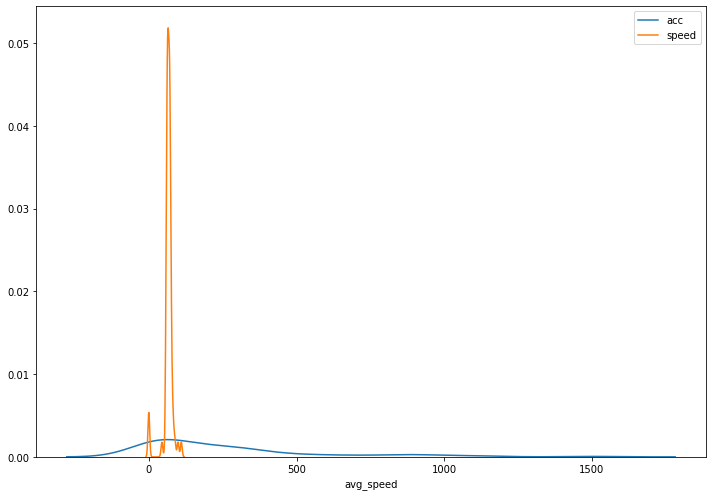

In [22]:
# Creating histogram 
fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True)
sns.distplot(df_atleast_one_accident['num_accidents'],hist=False, label = 'acc')
sns.distplot(df_atleast_one_accident['avg_speed'],hist=False, label = 'speed')

# sns.distplot(gapminder['lifeExp'], kde=False, color='red', bins=100)
plt.legend()
plt.show()


In [23]:
df_atleast_one_accident.sort_values(by = 'avg_speed')

,num_cameras,avg_speed,avg_volume,num_signals,num_signs,num_accidents
70,0,0.000000,0.000000,0,26,1
8,0,0.000000,0.000000,0,27,2
39,0,0.000000,10200.000000,0,165,1
55,22,44.259012,15870.370370,223,33352,1503
54,8,57.833133,29086.923077,77,12664,895
45,9,58.443322,31340.814630,61,7203,912
67,6,59.104116,21158.991228,50,4424,850
44,3,59.433790,41029.411765,28,5720,822
5,1,59.673203,2509.433962,1,303,19
51,0,60.000000,8000.000000,0,63,8


# Finding spearman correlation

In [47]:
# method for calculating spearman coefficient
def compute_spearman_ranks(x_ranks,y_ranks):
    
    n = len(x_ranks)

    d_square = []
    # d^2 for each row of data ranks input 
    for x,y in zip(x_ranks,y_ranks):
        diff = x-y
        d_square.append(pow(diff,2))

    # sum of d^2     
    sum_d_squares = sum(d_square)

    # calculate spearman formula
    rho = 1 - (6*sum_d_squares/(n*(n**2-1)))

    return rho

# method for calculating ranks of the lists
def compute_rank_of_list(input_list):
    #create a list of value-index pairs
    input_list_index_pair = list(zip(input_list,range(len(input_list))))

    # sort the list 
    input_list_index_pair_sorted = sorted(input_list_index_pair)

    # create the list of ranks
    ranks = [0]*len(input_list)# initialize list with zero

    for i, item in enumerate(input_list_index_pair_sorted):
        ranks[item[1]] = i+1

    return ranks

In [48]:
df.head()
df_refined = df.replace(0, np.nan)
df_refined

,num_cameras,avg_speed,avg_volume,num_signals,num_signs,num_accidents
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,2000.000000,NaN,54.0,NaN
5,1.0,59.673203,2509.433962,1.0,303.0,19.0
6,1.0,66.206897,11914.826498,5.0,1486.0,53.0
7,NaN,80.445545,17805.128205,7.0,753.0,50.0
8,NaN,NaN,NaN,NaN,27.0,2.0
9,NaN,NaN,NaN,NaN,5.0,NaN


In [52]:
# for accident and cameras spearman coeffcient

# getting columns of accidents and cameras
df_acc_cameras = df_refined[['num_cameras', 'num_accidents']]
df_acc_cameras.dropna(inplace = True)

# getting list of ranks for num_cameras
df_cameras_ls = list(df_acc_cameras['num_cameras'])
df_cameras_rank = compute_rank_of_list(df_cameras_ls)


# getting list of ranks for num_accidents
df_accidents_ls = list(df_acc_cameras['num_accidents'])
df_accidents_rank = compute_rank_of_list(df_accidents_ls)

coefficient = compute_spearman_ranks(df_cameras_rank, df_accidents_rank)
print("The spearman coefficient between the cameras and the accidents are coefficient" + )



0.8937885253674728


C:\Users\Hp-user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
